# Datasets

This notebook presents the basic functionalities of the following classes:
* WNImage
* WNMask
* WNSegmentationItem

# WNImage test

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [4]:
import waternet 

from pystac_client import Client, ItemSearch
from geojson import Point

Installing patchify



In [5]:
'fastai' in sys.modules

True

In [1]:
import fastai

ModuleNotFoundError: No module named 'fastai'

In [7]:
import matplotlib.pyplot as plt
from waternet.wnimage import WNImage

In [8]:
%time img = WNImage.from_tile('31TCM', '2018-09-15')
img

CPU times: user 38.5 ms, sys: 157 µs, total: 38.6 ms
Wall time: 2.39 s


Img: S2B_MSIL2A_20180916T105649_R094_T31TCM_20201009T014903
Loaded bands: []

In [9]:
img.get_band('B03').shape

(5490, 5490)

In [10]:
img

Img: S2B_MSIL2A_20180916T105649_R094_T31TCM_20201009T014903
Loaded bands: ['B03']

In [11]:
%time cube = img.as_cube(['B04', 'B03', 'B02', 'B05'])

CPU times: user 1.16 s, sys: 349 ms, total: 1.51 s
Wall time: 3.04 s


In [12]:
cube.shape

(5490, 5490, 4)

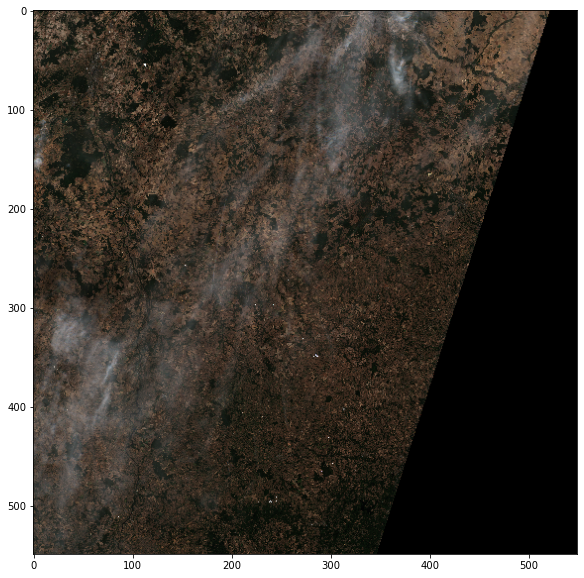

In [13]:
img.plot(['B04', 'B03', 'B02'])

In [14]:
from patchify import patchify, unpatchify

In [15]:
patches = patchify(cube, (549, 549, 3), step=549)

In [16]:
patches.shape

(10, 10, 1, 549, 549, 3)

In [17]:
reconstructed = unpatchify(patches, cube.shape)

In [18]:
reconstructed.shape

(5490, 5490, 4)

In [19]:
patches.reshape(-1, 549, 549, 3).shape

(100, 549, 549, 3)

In [20]:
import sys

In [21]:
"patchify" in sys.modules.keys()

True

# WNDataset test

In [22]:
# open one mask

import rasterio as rio
from pathlib import Path
import numpy as np

from waternet.wndataset import *

In [23]:
mask = WNMask('tmp3/S2B_MSIL2A_20180915T133219_R081_T22KEV_watermask.tif')

In [24]:
mask.mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 2, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)

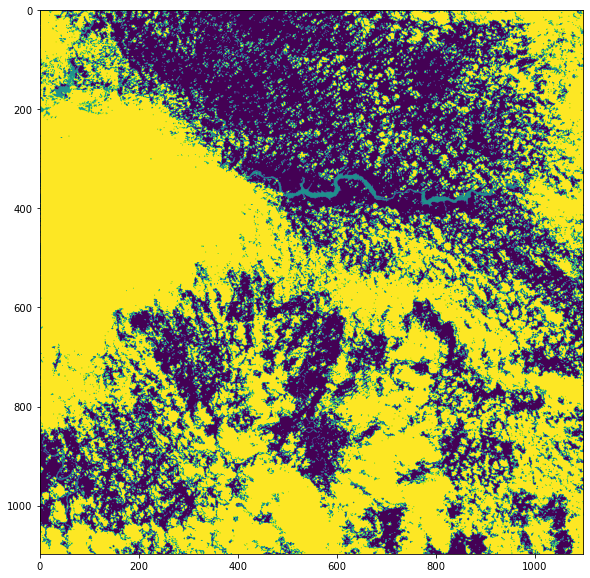

In [25]:
mask.plot()

In [26]:
item = WNSegmentationItem.from_mask('tmp3/S2B_MSIL2A_20180915T133219_R081_T22KEV_watermask.tif')

In [27]:
item.shape

(10980, 10980)

In [28]:
item.img.as_cube(['B04', 'B03', 'B02']).shape

(10980, 10980, 3)

In [29]:
len(item)

1764

In [30]:
item.patchify(['B04', 'B03', 'B02'])

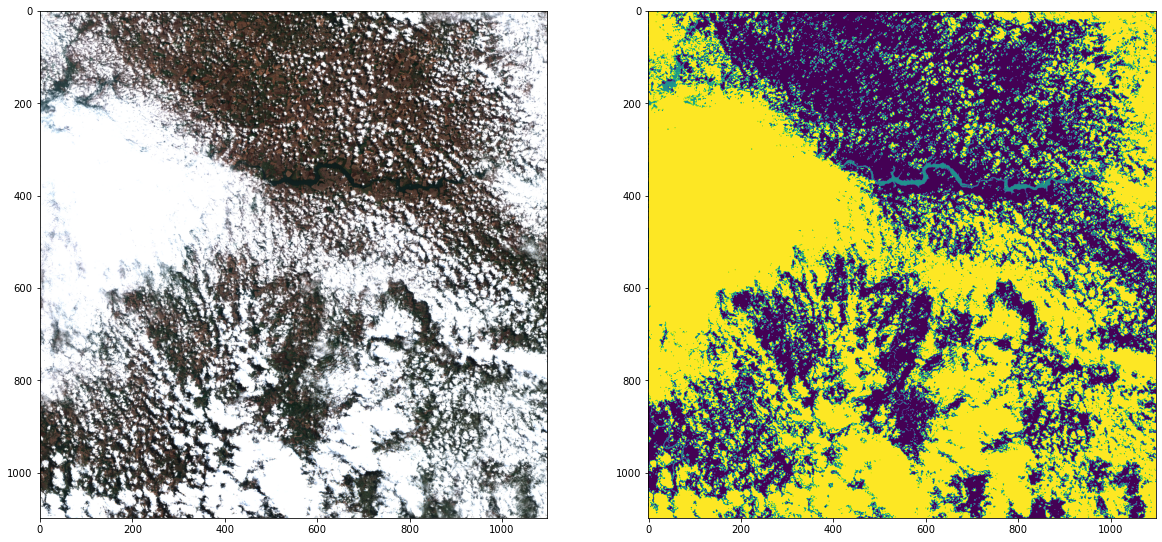

In [31]:
item.plot()

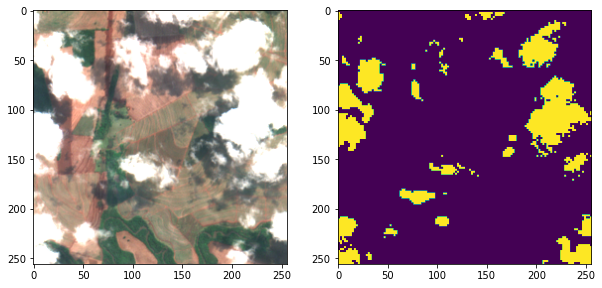

In [32]:
item.plot_patch(10, bright=5.)

In [33]:
from fastai.vision.all import *

In [39]:
# del dl
device = 'cuda:0'
device = 'cpu'
dl = DataLoader(dataset=item, bs=4, device=device)

In [40]:
dl.do_item(0)[1].shape

(256, 256)

In [41]:
item[0][0].dtype

dtype('float32')

In [42]:
b = dl.create_batch([item[0], item[1], item[2]])
b[0].dtype

torch.float32

In [43]:
t = dl.one_batch()[0]
t

tensor([[[[0.3566, 0.3542, 0.3618,  ..., 0.2354, 0.2268, 0.2114],
          [0.3462, 0.3470, 0.3552,  ..., 0.2192, 0.2170, 0.2018],
          [0.3482, 0.3398, 0.3254,  ..., 0.2202, 0.2054, 0.1974],
          ...,
          [0.5692, 0.5716, 0.6040,  ..., 0.4340, 0.4400, 0.4296],
          [0.5944, 0.5888, 0.6112,  ..., 0.4156, 0.4296, 0.4276],
          [0.6016, 0.5908, 0.6172,  ..., 0.4084, 0.4096, 0.4132]],

         [[0.3646, 0.3550, 0.3654,  ..., 0.2604, 0.2532, 0.2310],
          [0.3548, 0.3538, 0.3666,  ..., 0.2468, 0.2442, 0.2264],
          [0.3528, 0.3426, 0.3338,  ..., 0.2430, 0.2388, 0.2236],
          ...,
          [0.5512, 0.5648, 0.5980,  ..., 0.4400, 0.4464, 0.4352],
          [0.5888, 0.5856, 0.6112,  ..., 0.4196, 0.4320, 0.4320],
          [0.6000, 0.5960, 0.6212,  ..., 0.4090, 0.4232, 0.4208]],

         [[0.3784, 0.3696, 0.3770,  ..., 0.2632, 0.2554, 0.2352],
          [0.3692, 0.3692, 0.3830,  ..., 0.2482, 0.2476, 0.2256],
          [0.3686, 0.3652, 0.3526,  ..., 0

In [44]:
# for b in dl:
#     print(b[0].shape)

In [45]:
def loss_fn(pred, targ):
#     pdb.set_trace()
    
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

In [46]:
dls = DataLoaders(dl, dl)

In [47]:
learner = unet_learner(dls, resnet18, normalize=False, n_out=5, pretrained=True, loss_func=loss_fn)

/srv/conda/envs/notebook/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
learner.summary()

DynamicUnet (Input shape: 4 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [49]:
pred = learner.forward(b[0])

pred.shape

torch.Size([3, 5, 256, 256])

In [56]:
pred = learner.predict(b[0])

torch.Size([1, 3, 3, 256, 256])
torch.Size([1, 5, 256, 256])
2


In [57]:
pred[0].shape

torch.Size([1, 3, 3, 256, 256])

In [58]:
learner.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(valley=0.0002754228771664202)

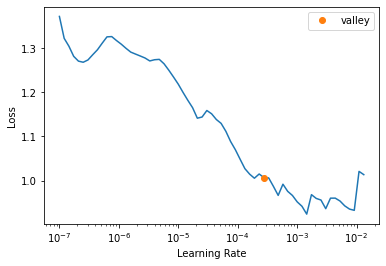

In [162]:
learner.cuda()
learner.lr_find()

In [164]:
learner.fit_one_cycle(10, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,time
0,0.297680,0.275589,01:41
1,0.286606,0.303318,01:44
2,0.221849,0.251351,01:44
3,0.201190,0.211486,01:44
4,0.182791,0.216549,01:44
5,0.170104,0.202082,01:44
6,0.160290,0.209473,01:44
7,0.151556,0.179786,01:44
8,0.148476,0.174483,01:45
9,0.157787,0.168158,01:45


In [165]:
learner.fit_one_cycle(10, lr_max=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,time
0,0.148394,0.170930,01:45
1,0.167422,0.187928,01:44
2,0.167408,0.187476,01:44
3,0.158520,0.193511,01:44
4,0.147907,0.182510,01:44
5,0.139048,0.168778,01:44
6,0.133933,0.160599,01:44
7,0.127781,0.158002,01:44
8,0.126196,0.162381,01:44
9,0.135393,0.153752,01:44


In [65]:
pred = learner.predict(b[0])

In [67]:
pred[0].shape, pred[1].shape

(torch.Size([1, 3, 3, 256, 256]), torch.Size([5, 256, 256]))

In [71]:
b[0].shape

torch.Size([4, 3, 256, 256])

In [72]:
len(pred)

3

In [122]:
b[0][None, ...].shape

(1, 3, 256, 256)

In [80]:
pred = learner.model.forward(b[0].cuda())

In [84]:
pred.shape

torch.Size([4, 5, 256, 256])

In [124]:
pred = learner.model.forward(Tensor(b[0][None, ...]).cuda())

In [125]:
pred.shape

torch.Size([1, 5, 256, 256])

In [117]:
b[0].shape

(3, 256, 256)

In [175]:
idx = slice(100, 110)

In [178]:
for i in range(idx.start, idx.stop):
    pass

In [180]:
i = range(1, 10)

In [ ]:
idxs = range(1, 10)

fig, ax = plt.subplots(len(idxs), 3, figsize=(15, len(idxs) * 5))

for i, idx in enumerate(idxs):
    inpt, targ = dls.create_item(idx)
    pred = learner.model.forward(Tensor(inpt[None, ...]).cuda()).squeeze()

    rgb = inpt.transpose((1, 2, 0))*2.
    rgb[rgb > 1] = 1
    ax[i][0].imshow(rgb)
    ax[i][1].imshow(targ)
    ax[i][2].imshow(pred.argmax(dim=0).cpu())

In [139]:
t = pred[idx]

IndexError: index 31 is out of bounds for dimension 0 with size 5

In [109]:
t.argmax(dim=0)

TensorBase([[0, 2, 2,  ..., 2, 2, 2],
        [0, 2, 2,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [2, 2, 0,  ..., 0, 2, 2],
        [2, 2, 0,  ..., 0, 2, 2]], device='cuda:0')

In [ ]:
dls.loaders

In [ ]:
dls.valid_ds

In [ ]:
b[0].shape

In [ ]:
b[1].shape

In [ ]:
b = dl.do_batch([item[0], item[1], item[2]])

In [ ]:
b[0].shape